# Melatih ulang model klasifikasi untuk Edge TPU menggunakan kuantisasi pasca-pelatihan (dengan TF2)

Dalam panduan ini, kita akan menggunakan TensorFlow 2 untuk membangun model klasifikasi gambar, melatihnya menggunakan dataset kucing & anjing, dan mengonversinya menjadi TensorFlow Lite melalui kuantisasi pasca-pelatihan. Model ini dibangun di atas MobileNet V2 yang telah dilatih sebelumnya, di mana awalnya kita melatih ulang hanya lapisan klasifikasi sambil menggunakan kembali lapisan ekstraktor fitur yang sudah dilatih. Selanjutnya, kita melakukan fine-tuning model dengan memperbarui bobot pada lapisan ekstraktor fitur tertentu, yang merupakan pendekatan lebih cepat dibandingkan melatih seluruh model dari awal. Setelah pelatihan selesai, kita menggunakan kuantisasi pasca-pelatihan untuk mengonversi semua parameter menjadi format int8, sehingga mengurangi ukuran model dan meningkatkan kecepatan inferensi. Format int8 ini sangat penting untuk kompatibilitas dengan Edge TPU yang terdapat pada perangkat Coral.

Lihat dokumentasi [coral.ai](https://coral.ai/docs/edgetpu/models-intro/) untuk informasi tambahan tentang cara membuat model yang kompatibel dengan Edge TPU. Penting untuk dicatat bahwa tutorial ini memerlukan TensorFlow 2.3 atau versi yang lebih baru untuk kuantisasi penuh, dan secara khusus mengharapkan model yang dibangun menggunakan Keras. Strategi konversi ini tidak kompatibel dengan model yang diimpor dari grafik beku (frozen graph). Jika Anda menggunakan TensorFlow 1.x, Anda dapat merujuk ke [versi 1.x dari tutorial ini](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf1.ipynb).

## Import the required libraries

Untuk melakukan kuantisasi pada tensor input dan output, Anda harus menggunakan API `TFLiteConverter`, yang tersedia di versi TensorFlow 2.3 atau yang lebih baru.

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

## Prepare the training data

Awalnya, kita akan mengunduh dan mengatur dataset kucing & anjing yang akan digunakan untuk melatih ulang model. Sangat penting untuk memperhatikan bagian ini jika Anda ingin mereplikasi proses ini di masa depan dengan dataset gambar kustom Anda. Secara khusus, perhatikan bahwa direktori "PATH" diatur dengan folder yang memiliki nama sesuai untuk setiap kelas. Kode yang disediakan akan mengacak dan membagi foto menjadi set pelatihan dan validasi, serta membuat file label yang berasal dari nama folder foto.

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
PATH

'/root/.keras/datasets/cats_and_dogs_filtered'

Selanjutnya, kita menggunakan [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) untuk mereskalakan data gambar menjadi nilai float (dibagi dengan 255 sehingga nilai tensor berada di antara 0 dan 1), dan memanggil `flow_from_directory()` untuk membuat dua generator: satu untuk dataset pelatihan dan satu lagi untuk dataset validasi.

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Ubah jika Anda memiliki jenis masalah yang berbeda (misalnya, binary)
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Ubah jika Anda memiliki jenis masalah yang berbeda (misalnya, binary)
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Pada setiap iterasi, generator ini menyediakan sekumpulan gambar dengan membaca gambar dari disk dan memprosesnya ke ukuran tensor yang tepat (224 x 224). Outputnya adalah tuple (gambar, label). Misalnya, Anda dapat melihat bentuknya di sini:

In [5]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 2))

Sekarang simpan label kelas ke dalam file teks:

In [6]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('catdogs_labels.txt', 'w') as f:
  f.write(labels)

{'cats': 0, 'dogs': 1}


In [7]:
!cat catdogs_labels.txt

cats
dogs

## Bangun model

Sekarang, kita akan membangun model yang dirancang untuk pembelajaran transfer khususnya pada lapisan akhir yang terhubung sepenuhnya.

Dimulai dengan MobileNet V2 Keras sebagai model dasar, yang awalnya dilatih terlebih dahulu pada kumpulan data ImageNet (mencakup pelatihan untuk pengenalan 1.000 kelas). Ini memberi kita ekstraktor fitur yang sangat baik untuk klasifikasi gambar, yang memungkinkan kita untuk kemudian melatih lapisan klasifikasi baru yang disesuaikan dengan kumpulan data bunga kita.

In [8]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Membuat model dasar dari MobileNet V2 yang telah dilatih sebelumnya
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=2, activation='softmax')
])

### Konfigurasi model

Meskipun metode ini disebut `compile()`, ini pada dasarnya adalah langkah konfigurasi yang diperlukan sebelum kita dapat memulai pelatihan.


In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,626,722 (10.02 MB)

 Trainable params: 368,738 (1.41 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


## Melatih model

Sekarang kita dapat melatih model menggunakan data yang disediakan oleh `train_generator` dan `val_generator` yang telah kita buat sebelumnya.  

Proses ini seharusnya memakan waktu kurang dari 10 menit.

In [13]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 652ms/step - accuracy: 0.6449 - loss: 1.8163 - val_accuracy: 0.9350 - val_loss: 0.4100
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.8904 - loss: 0.4155 - val_accuracy: 0.9640 - val_loss: 0.3747
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.9484 - loss: 0.3843 - val_accuracy: 0.9700 - val_loss: 0.3516
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.9693 - loss: 0.3414 - val_accuracy: 0.9750 - val_loss: 0.3340
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.9845 - loss: 0.3313 - val_accuracy: 0.9780 - val_loss: 0.3174
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


### Plot

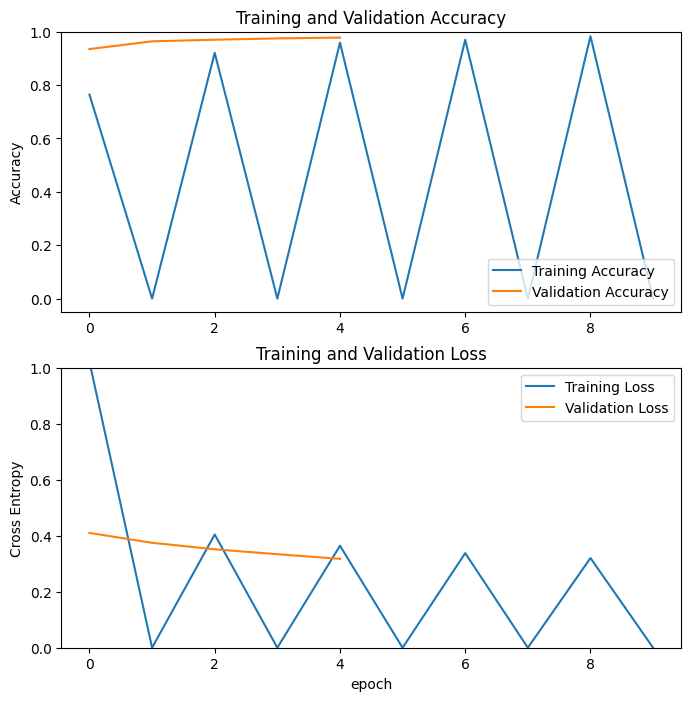

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Sempurnakan model dasar

Sejauh ini, pelatihan fokus pada lapisan klasifikasi, dan bobot dari jaringan yang telah dilatih sebelumnya tetap *tidak berubah*.

Untuk meningkatkan akurasi, salah satu pendekatannya adalah dengan melatih atau "fine-tuning" lapisan tambahan dari model yang telah dilatih sebelumnya. Dengan kata lain, kita akan membuka kunci (unfreeze) lapisan-lapisan tertentu dari model dasar dan memodifikasi bobotnya, yang awalnya dilatih pada 1.000 kelas ImageNet, agar lebih sesuai dengan fitur-fitur yang ada pada dataset kucing & anjing kita.

### Buka pembekuan lebih banyak lapisan

Jadi, daripada membekukan seluruh model dasar, kita akan membekukan lapisan-lapisan individual.

Pertama, mari kita lihat berapa banyak lapisan yang ada dalam model dasar:

In [15]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


Mari kita coba bekukan hanya 100 lapisan terbawah.

In [16]:
base_model.trainable = True
fine_tune_at = 100

# Bekukan semua lapisan sebelum lapisan `fine_tune_at`
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Konfigurasikan ulang model

Sekarang konfigurasikan model lagi, tetapi kali ini dengan tingkat pembelajaran yang lebih rendah (nilai default adalah 0,001).

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,626,722 (10.02 MB)

 Trainable params: 2,230,178 (8.51 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [19]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 58


### Lanjutkan pelatihan

Sekarang mari kita sempurnakan semua lapisan yang dapat dilatih. Ini dimulai dengan bobot yang telah kita latih di lapisan klasifikasi, jadi kita tidak memerlukan banyak periode.

In [20]:
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator),
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 636ms/step - accuracy: 0.7421 - loss: 0.5584 - val_accuracy: 0.9760 - val_loss: 0.3171
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.8998 - loss: 0.3556 - val_accuracy: 0.9710 - val_loss: 0.3194
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.9431 - loss: 0.3380 - val_accuracy: 0.9680 - val_loss: 0.3212


### Plot Baru

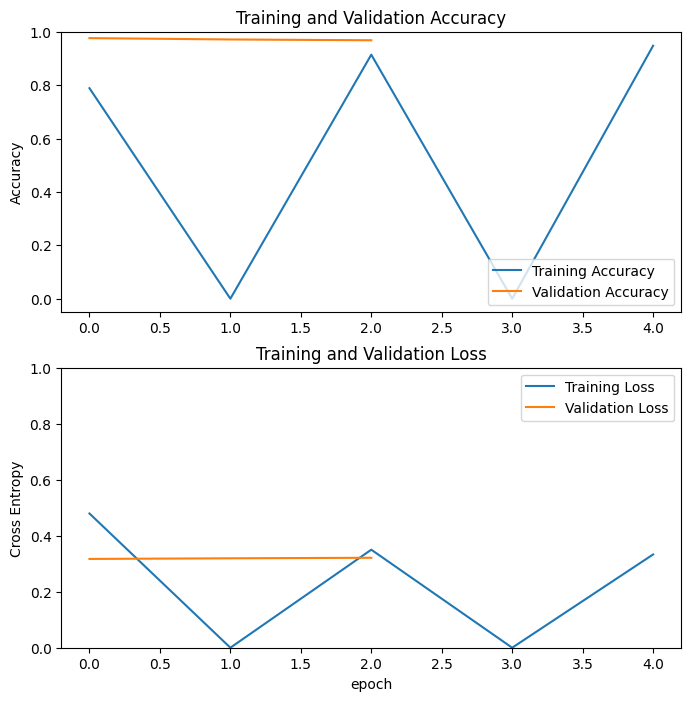

In [21]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Konversi ke TFLite

Biasanya, membuat model TensorFlow Lite hanya membutuhkan beberapa baris kode dengan [`TFLiteConverter`](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter). Sebagai contoh, ini akan membuat model TensorFlow Lite dasar (tanpa kuantisasi):

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpuj3eq1c5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132919431590160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919430093056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919430087248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919431593504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919430091472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919431592448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919430099744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919430100800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919430096928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919430099568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1329216863

Namun, file `.tflite` ini masih menggunakan nilai floating-point untuk data parameter, dan kita perlu melakukan kuantisasi penuh pada model ke format int8.

Untuk melakukan kuantisasi penuh pada model, kita perlu melakukan [kuantisasi pasca-pelatihan](https://www.tensorflow.org/lite/performance/post_training_quantization) dengan dataset yang representatif, yang memerlukan beberapa argumen tambahan untuk `TFLiteConverter`, serta sebuah fungsi yang membangun dataset yang representatif dari dataset pelatihan.

Jadi, mari kita konversi model ini lagi dengan kuantisasi pasca-pelatihan:

In [23]:
# Sebuah generator yang menyediakan dataset representatif
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(PATH + '/train/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Ini mengaktifkan kuantisasi
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Ini menetapkan dataset representatif untuk kuantisasi
converter.representative_dataset = representative_data_gen
# Ini memastikan bahwa jika ada operasi yang tidak bisa dikuantisasi, konverter akan melemparkan error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Untuk kuantisasi integer penuh, meskipun tipe yang didukung default-nya hanya int8, kita secara eksplisit menyatakannya untuk kejelasan.
converter.target_spec.supported_types = [tf.int8]
# Ini menetapkan input dan output tensor ke uint8 (ditambahkan pada r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224_quant.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpvrp90b8a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132919431590160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919430093056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919430087248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919431593504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919430091472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919431592448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919430099744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919430100800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919430096928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132919430099568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1329216863

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


### Bandingkan akurasinya

Jadi sekarang kita memiliki model TensorFlow Lite yang sepenuhnya terkuantisasi. Untuk memastikan konversi berjalan dengan baik, mari kita evaluasi model mentah dan model TensorFlow Lite.

Pertama-tama, periksa keakuratan model mentah:

In [24]:
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 96.875%


Sekarang mari kita periksa akurasi dari file `.tflite`, menggunakan dataset yang sama.

Namun, tidak ada API yang mudah untuk mengevaluasi akurasi model TensorFlow Lite, jadi kode ini menjalankan beberapa inferensi dan membandingkan prediksi dengan kebenaran dasar (ground truth):

In [25]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Input untuk model TFLite harus berupa uint8, jadi kita melakukan kuantisasi pada data input kita.
  # CATATAN: Langkah ini hanya diperlukan karena kita menerima data input dari
  # ImageDataGenerator, yang telah menormalkan semua data gambar ke dalam format float [0,1]. Ketika menggunakan
  # input bitmap, data sudah dalam format uint8 [0,255] jadi ini bisa diganti dengan:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Output dari model TFLite adalah uint8, jadi kita melakukan dekuantisasi pada hasil:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('mobilenet_v2_1.0_224_quant.tflite')
interpreter.allocate_tensors()

# Mengumpulkan semua prediksi inferensi dalam sebuah daftar
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Membandingkan semua prediksi dengan kebenaran dasar
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Akurasi Quant TF Lite: {:.3%}".format(tflite_accuracy.result()))


Akurasi Quant TF Lite: 96.875%


Anda mungkin melihat beberapa, tetapi semoga saja tidak terlalu banyak penurunan akurasi antara model mentah dan model TensorFlow Lite. Namun sekali lagi, hasil ini tidak cocok untuk penerapan produksi.

## Kompilasi untuk Edge TPU

Akhirnya, kita siap untuk mengkompilasi model untuk Edge TPU.

Pertama, unduh [Edge TPU Compiler](https://coral.ai/docs/edgetpu/compiler/):

In [26]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0  11725      0 --:--:-- --:--:-- --:--:-- 11747
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,197 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [1,423 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy

Kemudian kompilasi modelnya:

In [27]:
! edgetpu_compiler mobilenet_v2_1.0_224_quant.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1168 ms.

Input model: mobilenet_v2_1.0_224_quant.tflite
Input size: 2.94MiB
Output model: mobilenet_v2_1.0_224_quant_edgetpu.tflite
Output size: 3.12MiB
On-chip memory used for caching model parameters: 3.33MiB
On-chip memory remaining for caching model parameters: 4.36MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: mobilenet_v2_1.0_224_quant_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


Itu saja.

Model yang dikompilasi menggunakan nama file yang sama tetapi dengan "_edgetpu" yang ditambahkan di bagian akhir.

## Unduh modelnya

Anda dapat mengunduh file model dan label yang dikonversi dari Colab seperti ini:

In [28]:
from google.colab import files

files.download('mobilenet_v2_1.0_224_quant_edgetpu.tflite')
files.download('catdogs_labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Jika Anda mendapatkan kesalahan "Gagal mengambil" di sini, mungkin itu karena file belum selesai disimpan. Jadi tunggu sebentar dan coba lagi.

Perhatikan juga popup browser yang mungkin memerlukan persetujuan untuk mengunduh file.

## Jalankan model di Edge TPU

Sekarang Anda dapat menjalankan model pada perangkat Coral Anda dengan akselerasi di Edge TPU.

Untuk memulai, coba gunakan model `.tflite` Anda dengan [kode ini untuk klasifikasi gambar dengan API TensorFlow Lite](https://github.com/google-coral/tflite/tree/master/python/examples/classification).

Ikuti instruksi di halaman tersebut untuk menyiapkan perangkat Anda, salin file `mobilenet_v2_1.0_224_quant_edgetpu.tflite` dan `flower_labels.txt` ke Coral Dev Board atau perangkat dengan Coral Accelerator Anda, dan berikan foto bunga seperti ini:

```
python3 classify_image.py \
  --model mobilenet_v2_1.0_224_quant_edgetpu.tflite \
  --labels flower_labels.txt \
  --input flower.jpg
```

Notebook ini merujuk dari [coral.ai/examples](https://coral.ai/examples/#code-examples/). Periksa lebih banyak contoh di sana.